# Project 5: An Introduction to Neural Networks

**Double tap this cell to get to edit mode and fill in the information below.**

> Full Name:

> Date:

> Resources Used:

## Tips

  * Python tutorials:
     * [A short introduction](https://realpython.com/python-first-steps/)
     * [A more complete introduction](https://www.w3schools.com/python/default.asp)
     * PythonMinimum
  * Use __esc r__ to disable a cell
  * Use __esc y__ to reactivate it
  * Use __esc m__ to go to markdown mode. **Markdown** is the typesetting language used in jupyter notebooks.
  * In a markdown cell, double tap the mouse or glide pad (on your laptop) to go to edit mode. 
  * Shift + return to execute a cell (including markdown cells).
  * If the equations don't typeset, try double tapping the cell again, and re-execute it.
  

## Learning Objectives
  * Learn how to build a simple machine learning (ML) model (that is, function) with **pytorch**.
  * Learn how to tweak the model to improve its ability to identify handwritten digits. 


## Introduction
Everyone has surely heard of [ChatGPT](https://openai.com/chatgpt), the chatbot from OpenAI that seems to know everything about everything! Give it a prompt, and out pops a string of **tokens** that form very convincing human-like text. What is less well known is that the artificial intelligence (AI) that powers ChatGPT is just an enormously complicated 175 billion-parameter mathematical function, trained on essentially all the useful content of the internet and further tweaked by a team of humans to help ensure that the chatbot gives useful outputs. This function, called a transformer, computes about 170,000 probabilities to decide what the next token should be given the prompt and the current sequence of output tokens.

In this project, you'll be introduced to a very simple AI system that can identify (that is, classify) handwritten digits. The digits are represented as $28 \times 28 = 784$ gray-scale pixel images, which are a subset of the images from [MNIST](http://yann.lecun.com/exdb/mnist). We use a method called **supervised learning**. In supervised learning a model is repeatedly shown labeled objects, represented by a sequence of numbers, and the model (i.e., function) tries to predict the correct labels for the objects. The model parameters are adjusted and the sequence of steps is repeated until one finds no further improvement in the quality of the predictions. 

We use $N =$ 15,000 images for this training and 10,000 images for testing. Following good practice, we split the training data into a set for training and another set for validating the training. Crucially, the test data are not used in the training. (Why?)

The value of each pixel in the MNIST data set lies in the discrete set $[0, 1, \cdots, 255]$, which we rescale so that each pixel value lies in the unit interval. Note, since there are 784 pixels per image, we can think of each image as a point in a 784-dimensional space! Presumably, images that are of the same class, say a "7", tend to cluster together.


### Model

We'll use a model (i.e., function) called a fully-connected **shallow** neural network (SNN):

$$\mathbf{y} = \mbox{softmax}(\,\mathbf{b}_1 + \mathbf{w}_1 \, \mbox{relu}(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x}) \, ).$$

The tensors (arrays) $\mathbf{b}$ and $\mathbf{w}$ (called biases and weights, respectively) are the parameters of the model and $\mbox{relu}(x)$ is a function applied to every element $x$ of its tensor argument (i.e., applied element-wise). $\mbox{relu}(x)$ is defined by

\begin{align*}
\mbox{relu}(x) & = \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise}.
\end{cases}
\end{align*}

Another nonlinear function you may wish to try is $\text{tanh}(x)$ (`nn.Tanh`).

Here is a pictorial representation of smaller version of the above function (taken from [here](https://codeprogramming.org/2020/06/15/artificial-neural-network/)).
<img src="fig11_snn.png" align="left" alt="shallow neural network" width="400"/>
This neural network has 3 inputs, 5 so-called **hidden** nodes, and 2 outputs, that is, it is a (3, 5, 2) fully-connected neural network. The one in this project is a $(784, M, 10)$ neural network, where the choice of the number of hidden nodes, $M$, is up to you.

The arrays of parameters $\mathbf{b}_0$ and $\mathbf{w}_0$ are represented by the lines from the input layer to the hidden layer, while the arrays of parameters $\mathbf{b}_0$ and $\mathbf{w}_0$ are represented by the lines from the hidden layer to the output layer. Like the AI in ChatGPT, our extremely simple AI model outputs **probabilities**. We input an image of a handwritten digit as a sequence of 784 numbers, and our model will output 10 probabilities one for each of the ten digits 0 to 9. The digit with the highest probability will be taken as the prediction of our model.
Since $\mathbf{y}$ models class probabilities that must sum to unity, it makes sense to enforce this requirement. We'll do this with the **softmax** function for $K=10$ output classes, 
<br clear="left"/>

\begin{align*}
\mbox{softmax}(x_0,\cdots, x_9)_k & = \frac{\exp(x_k)}{\sum_{j=0}^{K-1} \exp(x_j)} ,
\end{align*}

where $x_{k}$ denotes the $k^\mbox{th}$ output of the hidden layer. 

The training of the above model is done by repeatedly presenting different **batches** of images tp the model. These batches are represented by a 2-index array $\mathbf{x}_{nj}$ of shape $(n, H \times W)$. (These arrays are referred to as **tensors**.) The first index (along dimension dim = 0) labels the ordinal value $j$ of an image in a batch of $n$ images, while the second index (along dim = 1) labels the pixels of a **flattened** image of height and width $H$ and $W$, respectively. The batches of data (here pixel values representing images) are called **training data**.

### Loss function
Typically, a machine learning model is fitted to the training data by minimizing a special function called the **average loss**, or the **cost function**, or the **empirical risk**, depending upon the field, defined by

\begin{align*}
    F(\omega) &= \frac{1}{N} \sum_{i=1}^N L(t_i, \, f(x_i, \omega)),  
\end{align*}

where $L(t, \, f)$ is called the **loss function** and measures how much one loses if the output of the parameterized function $y = f(x, \omega)$ differs from the **target** $t$. In our project, $t$ can be any of the values $0,\cdots, 9$. 

## Project Goal

You task is to experiment with different values of $M$ and different nonlinear functions `nn.Relu` and `nn.Tanh` for the hidden layer to find the best prediction accuracy.

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard module for displaying images
import imageio as im

# pytorch (AI/ML module)
import torch
import torch.nn as nn

# to reload modules
import importlib

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility 
# on a given machine
seed = 111
rnd  = np.random.RandomState(seed)

### Load Images

In [3]:
def loadImages(name):
    filename = f'data/{name:s}_x.csv.gz'
    # data type must be 32-bit float
    X = pd.read_csv(filename)['x'].to_numpy(dtype=np.float32).reshape(-1, 784)
    
    filename = f'data/{name:s}_t.csv.gz'
    T = pd.read_csv(filename)['t'].to_numpy()
    return X, T

train_x, train_t = loadImages('train')
test_x,  test_t  = loadImages('test')

train_x.shape, test_x.shape

((15000, 784), (10000, 784))

### Plot Images
Use imshow(..) and show() to display the image.

In [4]:
def plotImages(x, n_rows=2, n_cols=5, f_size=(5, 2)):
    f, ax = plt.subplots(nrows=n_rows, 
                         ncols=n_cols, 
                         figsize=f_size)
    # note use of flatten() to convert a matrix of shape (nrows, ncols)
    # to a 1-d array.
    for image, ax in zip(x, ax.flatten()):
        ax.imshow(image.reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

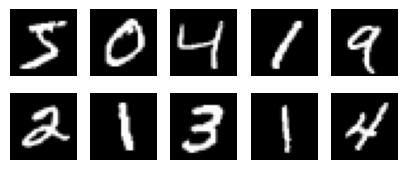

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [5]:
plotImages(train_x)
train_t[:10]

### Prepare training and validation sets

In [6]:
train_fraction = 10/15 # fraction of data used for training

# split data into training and validation set
M = int(train_fraction*len(train_x))

train_x, valid_x = train_x[:M], train_x[M:]
train_t, valid_t = train_t[:M], train_t[M:]

n_train = len(train_x)
n_valid = len(valid_x)
n_test  = len(test_x)

print("number of images for training:   %10d" % n_train)
print("number of images for validation: %10d" % n_valid)
print("number of images for testing:    %10d" % n_test)

number of images for training:        10000
number of images for validation:       5000
number of images for testing:         10000


### Define model/training hyperparameters

Things to try.
  1. Change $M$.
  1. Change `n_iter`
  1. Change `n_batch`
  1. Change `learning_rate`
  1. Change `nonlinearity` (e.g., `nn.Tanh`, `nn.Sin`)

In [7]:
M = 4                     # number of hidden nodes
n_iter  = 20000           # number of iterations
n_batch = 50              # batch size
learning_rate = 1.e-3     # ask Prof.!
nonlinearity  = nn.ReLU() 

model = nn.Sequential(nn.Linear(784,  M), nonlinearity,
                      nn.Linear( M,  10), nn.Sigmoid())
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=10, bias=True)
  (3): Sigmoid()
)


### Define average loss function
Here we use the cross entropy loss, which is defined by
\begin{align*}
  H(p, q) & = -\sum_i p_i \log q_i,\\
            & \approx -\frac{1}{N}\sum_{i=0}^{N-1} \log q_i.
\end{align*}

In principle, we want $N \rightarrow \infty$, but, in practice, $N = n\_batch$. This is done to produce a noisy approximation of
the cross entropy and, therefore, a noisy approximation of the local
gradient. The stochasticity introduced increases the probability that the minimizer won't get stuck in a bad local minimum and will move on to a better one.

In [8]:
# The class below does the same thing as the PyTorch class
# nn.CrossEntropyLoss()

class AverageLoss():
    def __init__(self):
        pass
    
    def __call__(self, outputs, targets):
        """
    Compute the cross entropy defined by
        H(p, q) = -sum_i p_i log(q_i),
                = -(1 / T) sum_i=0^T-1 log(q_i)
 
    which is minimized when the estimated probability q_i for the
    ith feature vector matches the true probability p_i.
 
    outputs: estimated class probabilities
             shape: (batch_size, number_classes) 
    targets: class indices [0,...,K-1], shape: (batch_size, ) 
        """
        # For each feature vector i, pick the estimated probability q_i
        # that corresponds to its true class index. The true class 
        # indices for the feature vectors (the images) are given in 
        # targets.
        #
        # Note the very powerful numpy-like syntax for accessing 
        # specific elements of an nd-array: outputs[list1, list2].
        # basically, for each row i we pick the value in the column 
        # number given in target[i]. 
        # Note also: range(batch_size) is [0,...batch_size-1].
        batch_size = len(outputs)
        outputs = outputs[range(batch_size), targets]
        
        # compute H(p, q) = -sum_i p_i log(q_i)
        return -torch.sum(torch.log(outputs)) / batch_size 

In [9]:
#avloss = AverageLoss()

avloss = nn.CrossEntropyLoss()

### Get batch
Get a random batch of images of size `batch_size` from the training data. 

In [10]:
def randomBatch(train_x, train_t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "number" integers from the range [0, length-1]
    rows    = rnd.choice(len(train_x), batch_size)
    batch_x = train_x[rows]
    batch_t = train_t[rows]
    return batch_x, batch_t

### Accuracy
Compute fraction of correct predictions.

In [11]:
def accuracy(outputs, targets):
    # We take the ordinal value of the highest of the 10 outputs as the
    # predicted class index. Use the numpy function argmax to do this.
    #
    # argmax scans the numpy array along the specified axis, here the 
    # horizontal axis (axis=1), which is in the class direction, and 
    # returns the ordinal value of the maximum value along that axis, 
    # which will be the predicted class index.
    #
    # Note the required use of detach().numpy() to return the tensor outputs 
    # as a numpy array, which is the argument type expected by argmax.
    
    probs   = outputs.detach().numpy()
    
    outputs = np.argmax(probs, axis=1)
    
    # Count how many times the predicted class index matches the true 
    # class index of the image and convert to a fraction.
    
    labels  = targets.detach().numpy()
    
    return float(np.mean(outputs==labels))

### Trainer

In [12]:
def train(model, optimizer, avloss, train_x, train_t, batch_size):
    # set mode to training so that training specific operations are enabled.
    model.train()
    
    # Get a random sample (a batch) of images (as numpy arrays)
    batch_x, batch_t = randomBatch(train_x, train_t, batch_size)
        
    # Convert the numpy arrays batch_x and batch_t, the images and 
    # class indices, respectively, to tensor types. The later is the 
    # expected type into models and the avarage loss functions.
    #
    # The PyTorch tensor type is the magic that permits automatic 
    # differentiation with respect to parameters of the average loss. 
    # However, we do not need the derivatives with respect to 
    # the images, x, and the class indices, t, so we disable it.
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(batch_x)
        t = torch.from_numpy(batch_t)      

    # compute the output of the model for the batch of images x
    outputs = model(x)
    
    # compute a noisy approximation to the average loss
    loss    = avloss(outputs, t)
    
    # use automatic differentiation to compute a noisy approximation
    # of the local gradient
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients
    
    # Finally, advance one step in the direction of steepest descent,
    # using the noisy local gradient. Consider a 2-million dimensional 
    # hyper-surface defined by the average loss in the limit of an 
    # infinite training sample. In principle, that is the hyper-surface 
    # we really wish we could explore and whose global minimum we would
    # like to find. But, since this is impossible, we instead construct
    # at any given point on this hyper-surface a noisy approximation 
    # to it using the loss function averaged over a small batch of images. 
    # Then, we approximate the local gradient using the noisy local
    # approximation to the hyper-surface. Necessarily, the gradient 
    # will be a noisy approximation to the true local gradient. 
    #
    # This may seem like an odd thing to do. Surely, it is better to 
    # compute the local gradient using as large a training sample as 
    # possible in order to provide a more accurate approximation to 
    # the hyper-surface at any given point? However, that is actually 
    # a bad idea! Firstly, using the full training sample to define 
    # the average loss would drastically slow down the minimization. 
    # Secondly, the hyper-surface is likely to be highly corrugated 
    # with a huge number of local minima. 
    #
    # Gradient descent in such a landscape runs the risk that a minimizer
    # could fall into a local minimum and stay there. If the local
    # minimum is close to the global mininum there is no issue. But it
    # would be an issue if the local minimum is far from the global 
    # minimum, or at least a better local minimum.
    #
    # The use of noisy estimates of local gradients makes it possible for
    # a minimizer, just by chance, to escape from a local minimum and, 
    # therefore, more likely to find a better local minimum.
    # This idea suggests that perhaps we should begin with very 
    # noisy gradients. Then, if we notice the minimizer bouncing around 
    # neither going uphill nor downhill on the average, then we could 
    # surmise that it is actually bouncing around a minimum. Of course,
    # we can never be certain that this is the global minimum, but, if it
    # is, it would make sense to gradually increase the batch size until
    # the minimizer settles down.

    optimizer.step()       # move one step
        
def validate(model, train_x, train_t, valid_x, valid_t):
    # make sure we set evaluation mode so that training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        # compute accuracy using training sample
        x = torch.from_numpy(train_x)
        t = torch.from_numpy(train_t)
        o = model(x)
        acc_t = accuracy(o, t)
  
        # compute accuracy using validation sample
        x = torch.from_numpy(valid_x)
        t = torch.from_numpy(valid_t)
        o = model(x)
        acc_v = accuracy(o, t)

    return (acc_t, acc_v)
               
def trainModel(model, optimizer, avloss, 
               train_x, train_t,
               valid_x, valid_t,
               n_iterations, batch_size):
    xx   = []
    yy_t = []
    yy_v = []

    step = 100
    
    print("%10s\t%10s\t%10s" % ("iteration", "trainset", "validset"), end='')

    for ii in range(n_iterations):
        
        # do one step of minimization
        
        train(model, optimizer, avloss, 
              train_x, train_t, 
              batch_size)

        # print out accuracies on training and validation data sets
        
        if ii % step == 0:
            acc_t, acc_v = validate(model, 
                                    train_x, train_t, 
                                    valid_x, valid_t)
            
            print("\r%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v), end='')
        
            xx.append(ii)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
    return (xx, yy_t, yy_v)

### Choose minimizer

In [13]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

In [14]:
xx, yy_t, yy_v = trainModel(model, optimizer, avloss,
                            train_x, train_t, 
                            valid_x, valid_t,
                            n_iter, n_batch)
print("\ndone!")

     19900	    0.5265	    0.5102
done!


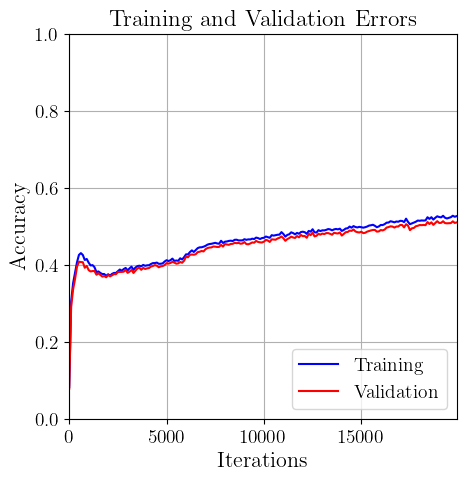

In [15]:
def plot(xx, yy_t, yy_v):
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    # adjust y limits
    ax.set_ylim((0.0, 1))
    ax.set_xlim((0, xx[-1]))
    
    ax.plot(xx, yy_t, 'b', label='Training')
    ax.plot(xx, yy_v, 'r', label='Validation')
    
    ax.set_title('Training and Validation Errors')
    ax.set_xlabel('Iterations', fontsize=16)
    ax.set_ylabel('Accuracy', fontsize=16)   
    
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='lower right')
    
    plt.show()
    
plot(xx, yy_t, yy_v)

### Compute accuracy of model

In [16]:
def compute(model, X, T):
    # make sure we set evaluation mode so that training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        # compute accuracy using training sample
        x = torch.from_numpy(X)
        t = torch.from_numpy(T)
        o = model(x)
        acc = accuracy(o, t)
    return acc

acc_test = compute(model, test_x, test_t)
print(f'accuracy(test): {acc_test:5.3f}')

accuracy(test): 0.515


### Save trained model

In [17]:
torch.save(model.state_dict(), 'mnist_snn.pt')